# Biblioteca e Leitura dos Dados

In [10]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [2]:
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'

C:\Users\Gustavo\AppData\Local\Temp\ipykernel_17892\4183850112.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


In [3]:
df_final = pd.read_csv("data/DF_FINAL.csv", index_col='TEMPO')
df_final.index = pd.to_datetime(df_final.index)
df_actions = pd.read_csv("data/DF_ACTION.csv", index_col='TEMPO')
df_actions.index = pd.to_datetime(df_actions.index)
df = pd.concat([df_final, df_actions], axis=1)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10081 entries, 2024-07-15 00:00:00 to 2024-07-22 00:00:00
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   H2_NORM                 10081 non-null  float64
 1   METANO_NORM             10081 non-null  float64
 2   PCA_PROP1               10081 non-null  float64
 3   PCA_PROP2               10081 non-null  float64
 4   PCA_PROP3               10081 non-null  float64
 5   PCA_PROP4               10081 non-null  float64
 6   PCA_TEMP_ATM            10081 non-null  float64
 7   MAX_QDIFF               10081 non-null  float64
 8   POTENCIA_ATIVA_GERADOR  10081 non-null  float64
dtypes: float64(9)
memory usage: 787.6 KB


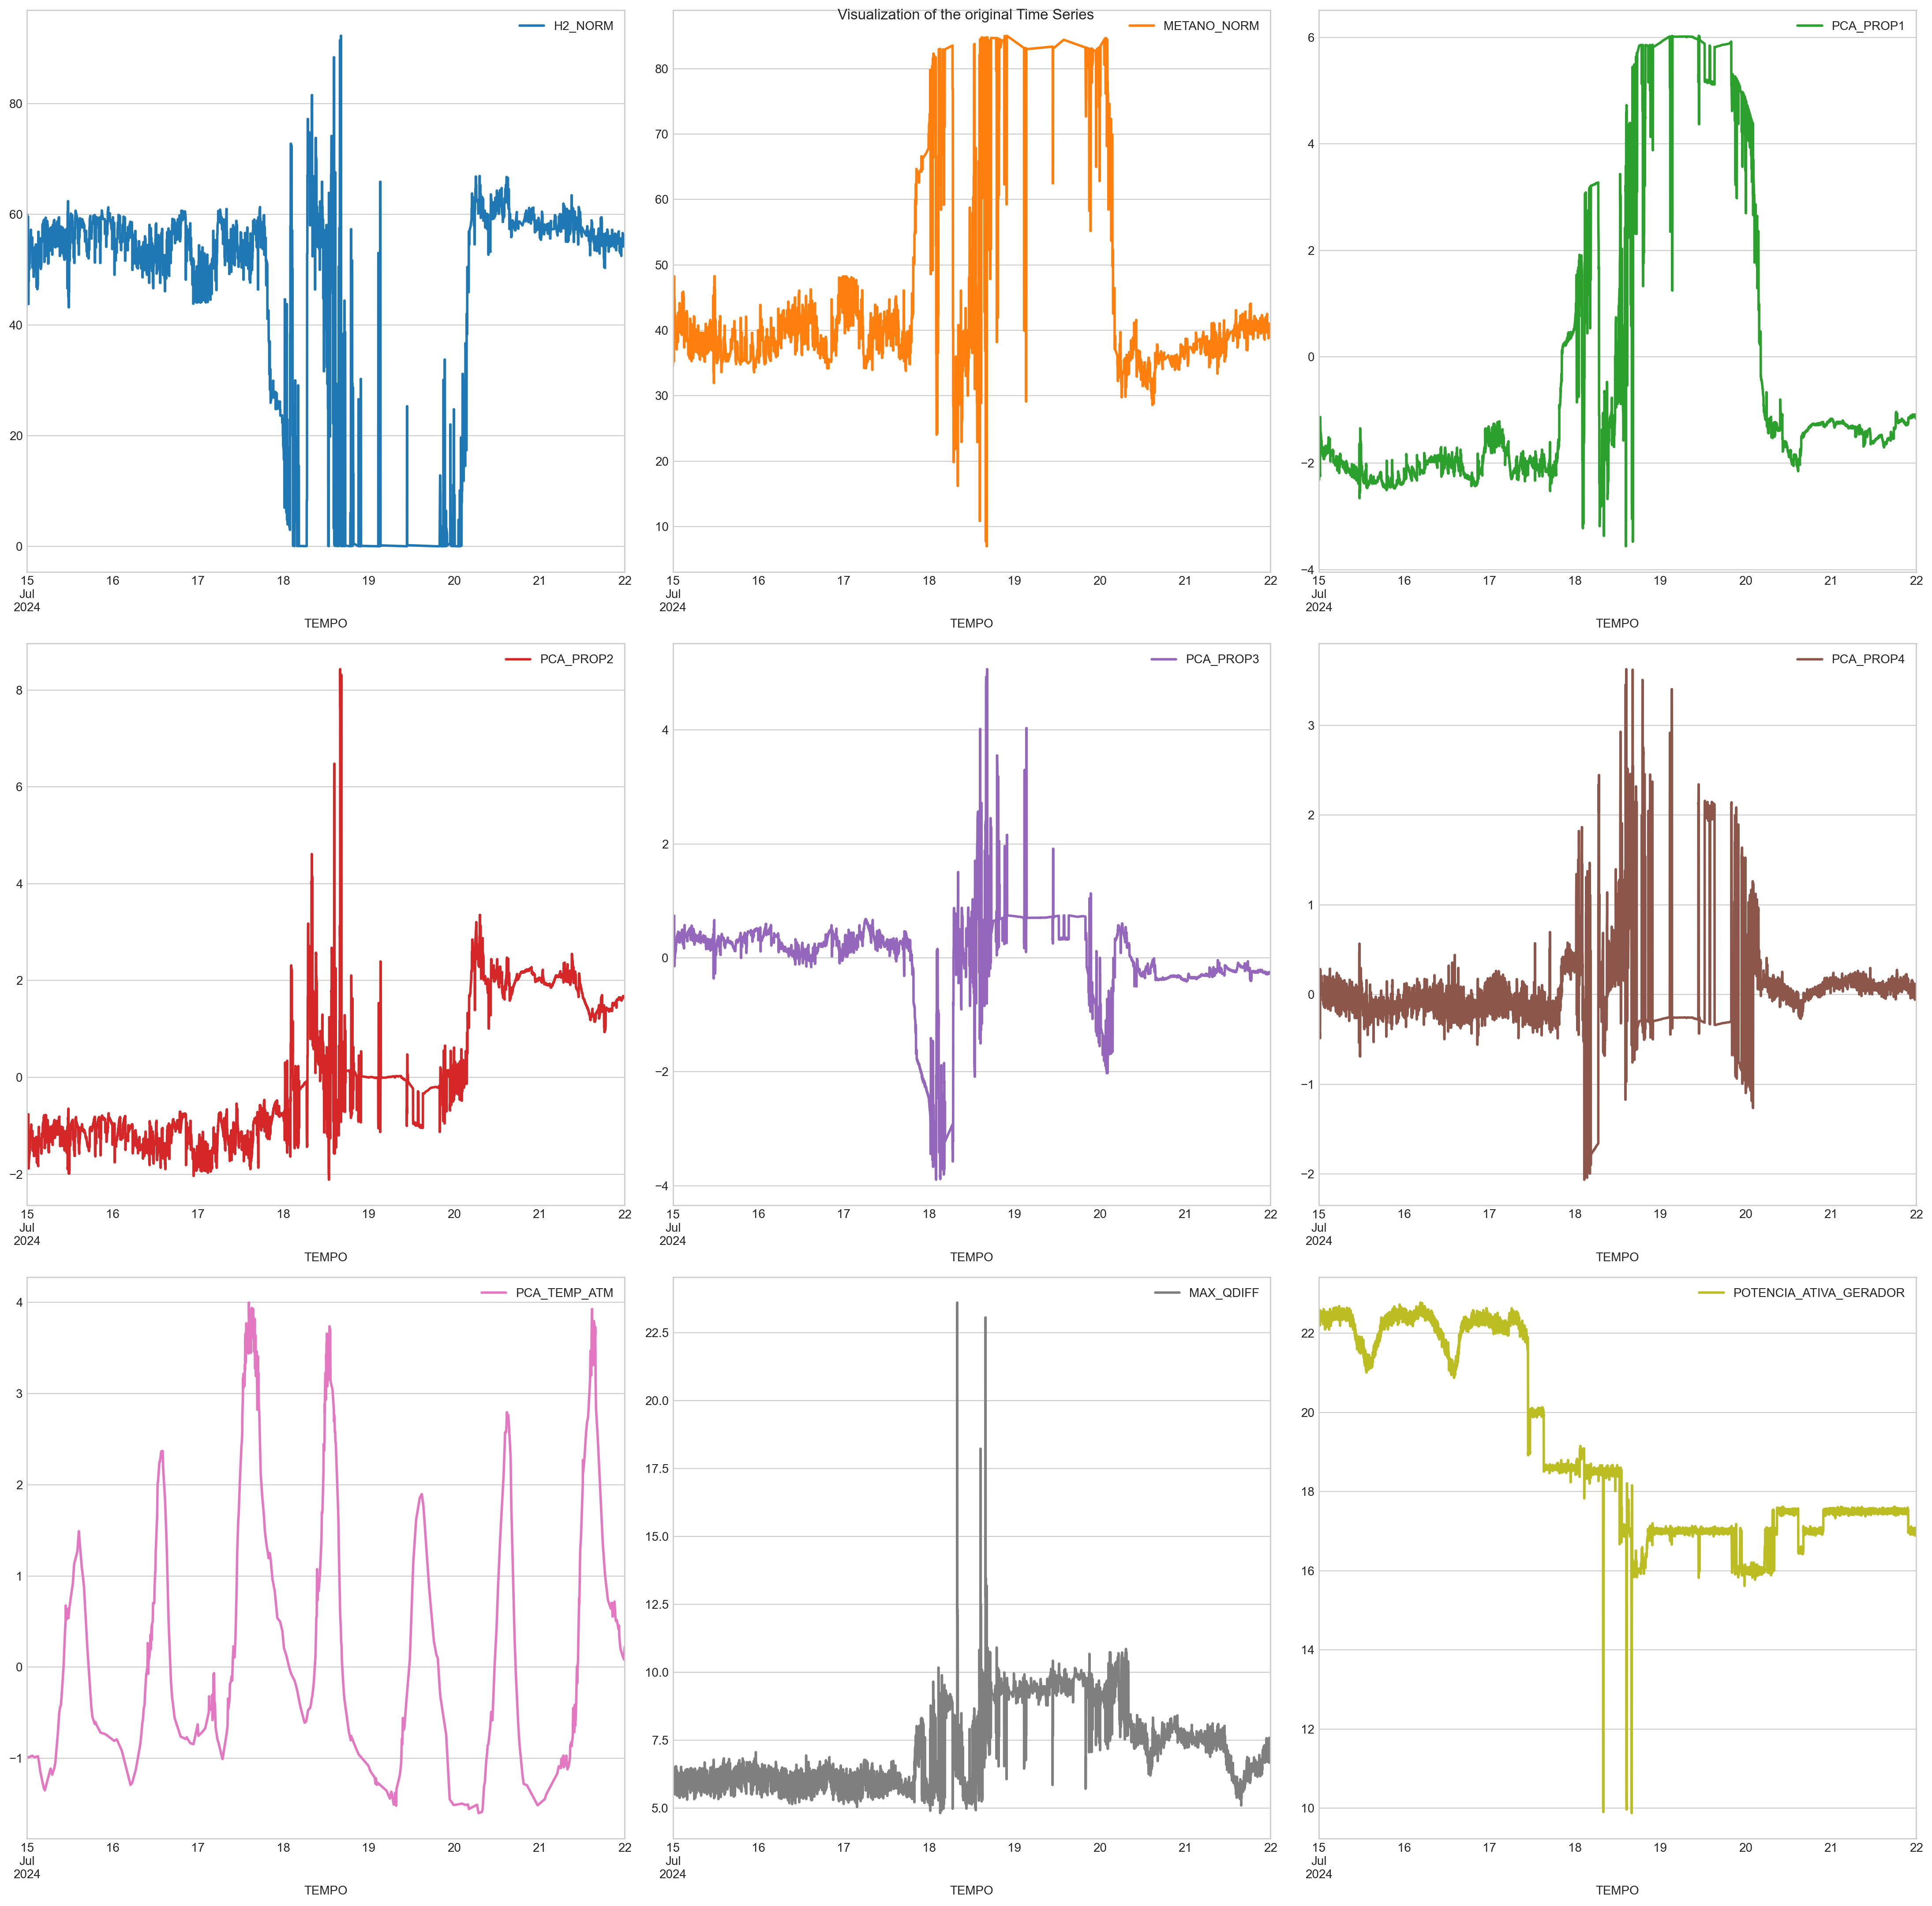

In [4]:
# Plot the time series
df.plot(subplots=True,
        layout=(3, 3),
        figsize=(22,22),
        fontsize=10, 
        linewidth=2,
        sharex=False,
        title='Visualization of the original Time Series')
plt.show()

# Feature Engineering do Target

In [5]:
def make_target(df, periods):
    df_target = pd.DataFrame({'TARGET': [0] * len(df)}, index=df.index)
    for time in periods:
        df_target.loc[time[0]:time[1], 'TARGET'] = 1
    return df_target

In [6]:
periods = []
periods.append(('2024-07-18 07:30:00','2024-07-18 21:00:00'))
df_target = make_target(df, periods)

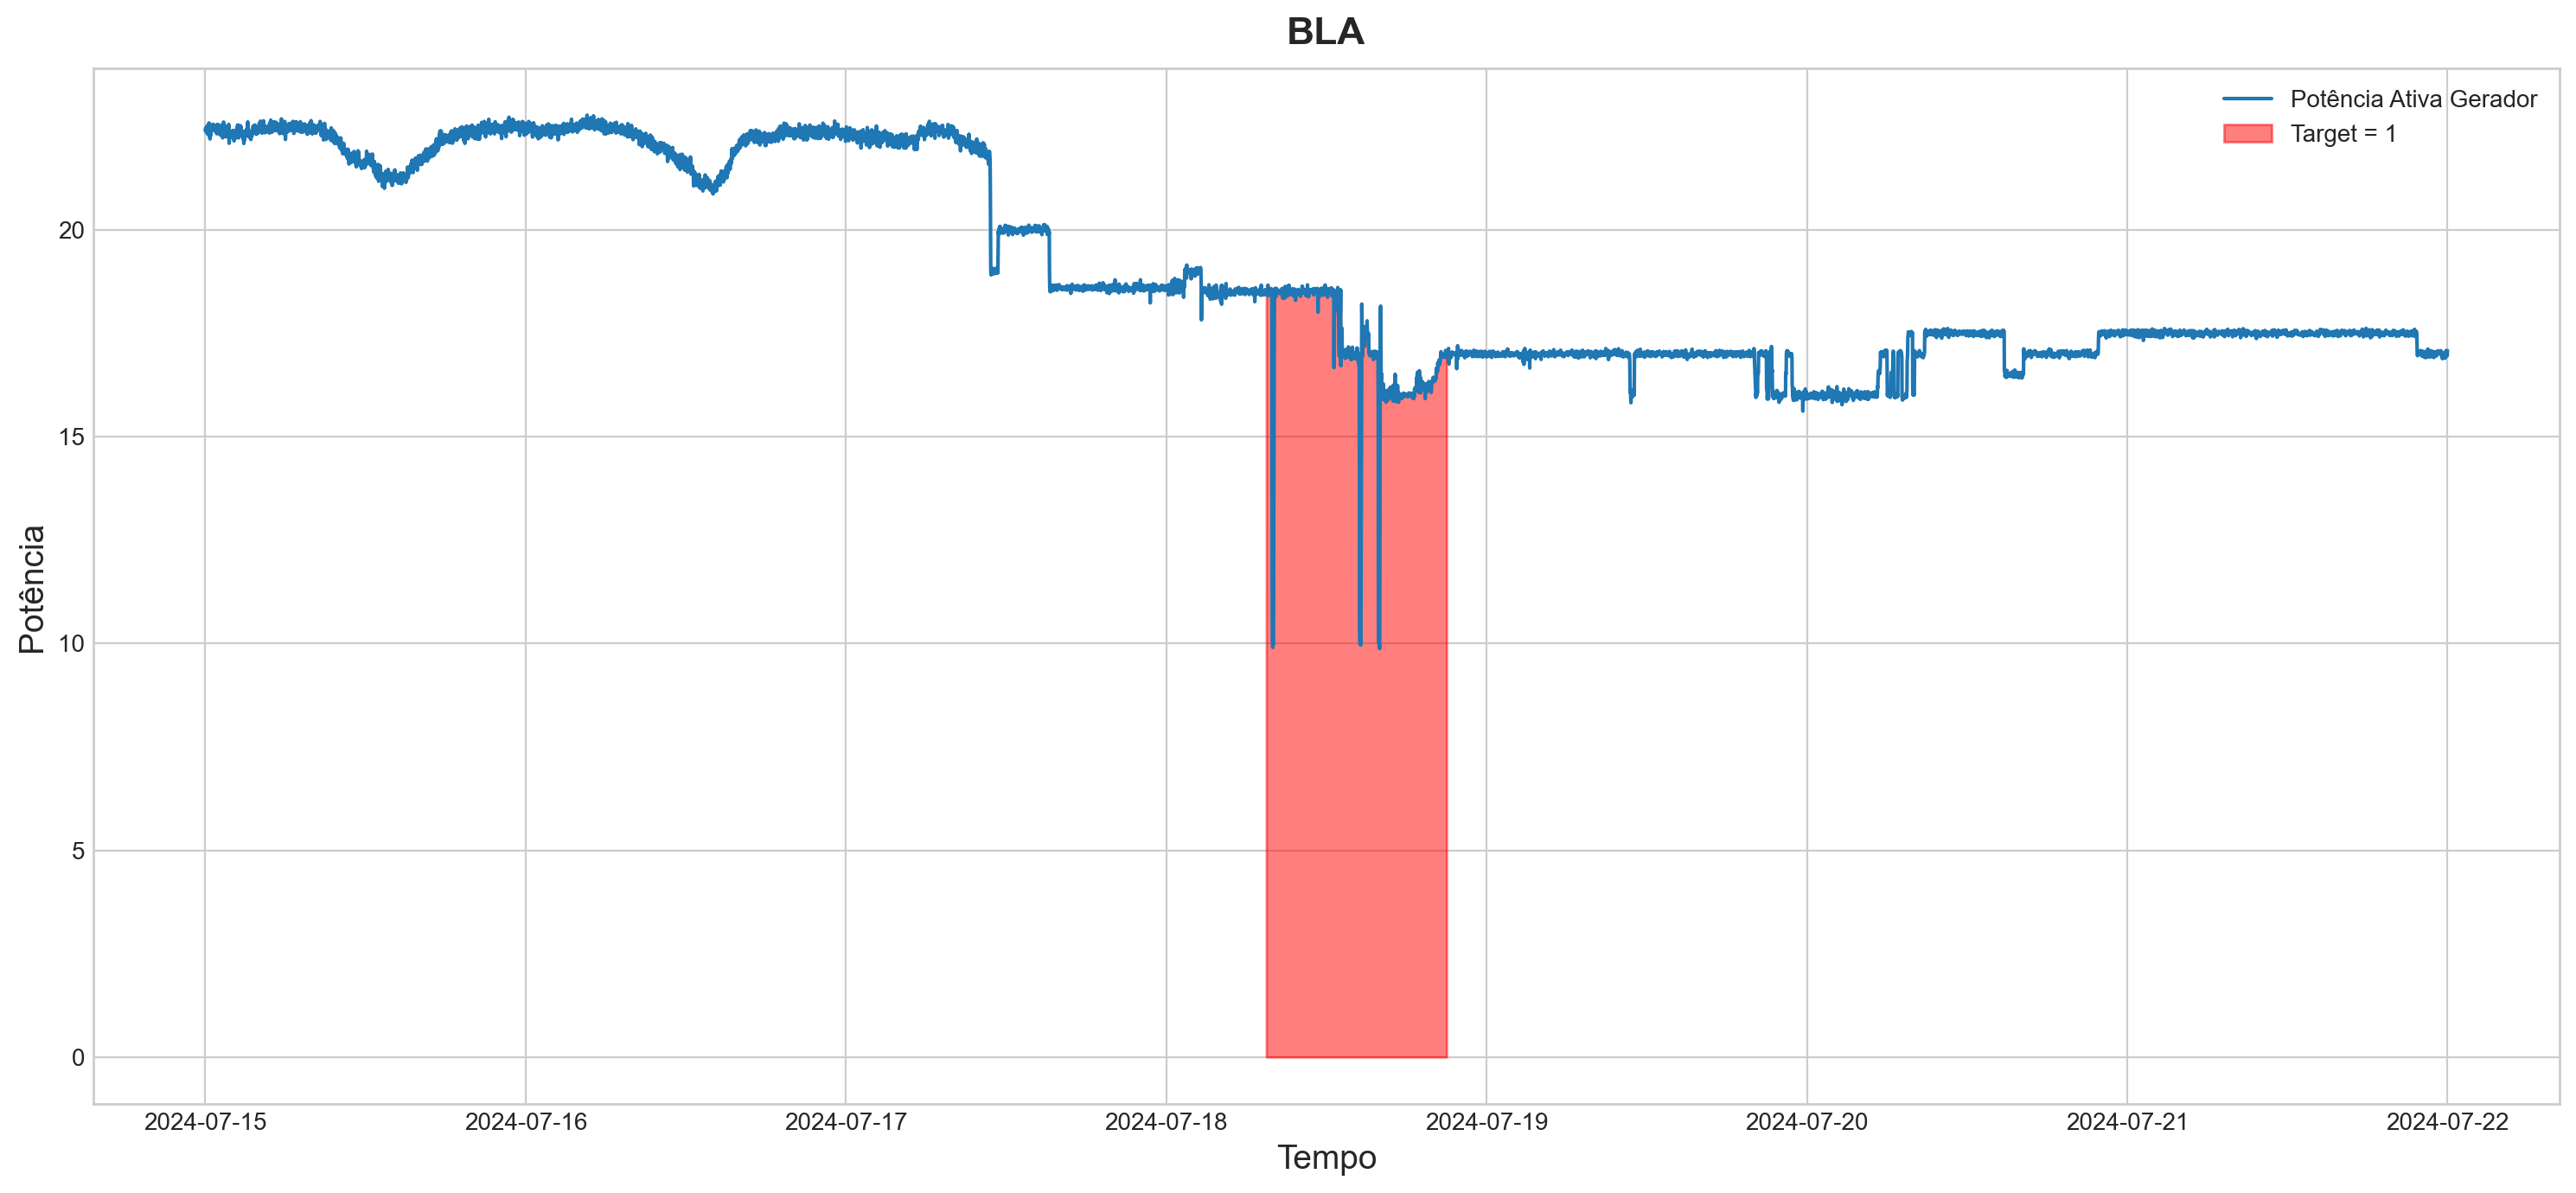

In [7]:
plt.figure(figsize=(15, 7))
plt.plot(df["POTENCIA_ATIVA_GERADOR"], label='Potência Ativa Gerador')
plt.xlabel('Tempo', fontsize=14)
plt.ylabel('Potência', fontsize=14)
plt.title('BLA')
plt.grid(True)

plt.fill_between(df.index, df["POTENCIA_ATIVA_GERADOR"], 
                 where=(df_target['TARGET'] == 1), 
                 color='red', alpha=0.5, label='Target = 1')

plt.legend()
plt.show()

# Split e Normalização

In [22]:
def split_time_series(df, df_target, split_date=None, percentage=None):
    if percentage is not None:
        split_index = int(len(df) * percentage)
        df_train = df.iloc[:split_index]
        df_test = df.iloc[split_index:]
        
        target_train = df_target.iloc[:split_index]
        target_test = df_target.iloc[split_index:]
    elif split_date is not None:
        df_train = df.loc[df.index < split_date]
        df_test = df.loc[df.index >= split_date]
        
        target_train = df_target.loc[df_target.index < split_date]
        target_test = df_target.loc[df_target.index >= split_date]
    else:
        raise ValueError("You must specify either split_date or percentage")
    return df_train, df_test, target_train, target_test

In [27]:
def scale_time_series(df_train, df_test, scaler=StandardScaler()):
    scaler.fit(df_train)    
    df_train_scaled = pd.DataFrame(scaler.transform(df_train), columns=df_train.columns, index=df_train.index)
    df_test_scaled = pd.DataFrame(scaler.transform(df_test), columns=df_test.columns, index=df_test.index)
    
    return df_train_scaled, df_test_scaled, scaler

In [21]:
train_features, test_features, train_labels, test_labels = split_time_series(df, df_target, percentage=0.7)

T = 45  # timesteps window
prepend_features = train_features.iloc[-(T-1):]
test_features = pd.concat([prepend_features, test_features], axis=0)

train_features.shape, train_labels.shape, test_features.shape, test_labels.shape

((7056, 9), (7056, 1), (3069, 9), (3025, 1))

In [28]:
# scaled_train_features, scaled_test_features, scaler = scale_time_series(train_features, test_features, scaler=StandardScaler())
scaled_train_features, scaled_test_features, scaler = scale_time_series(train_features, test_features, scaler=MinMaxScaler())
scaled_train_features.shape, scaled_test_features.shape

((7056, 9), (3069, 9))

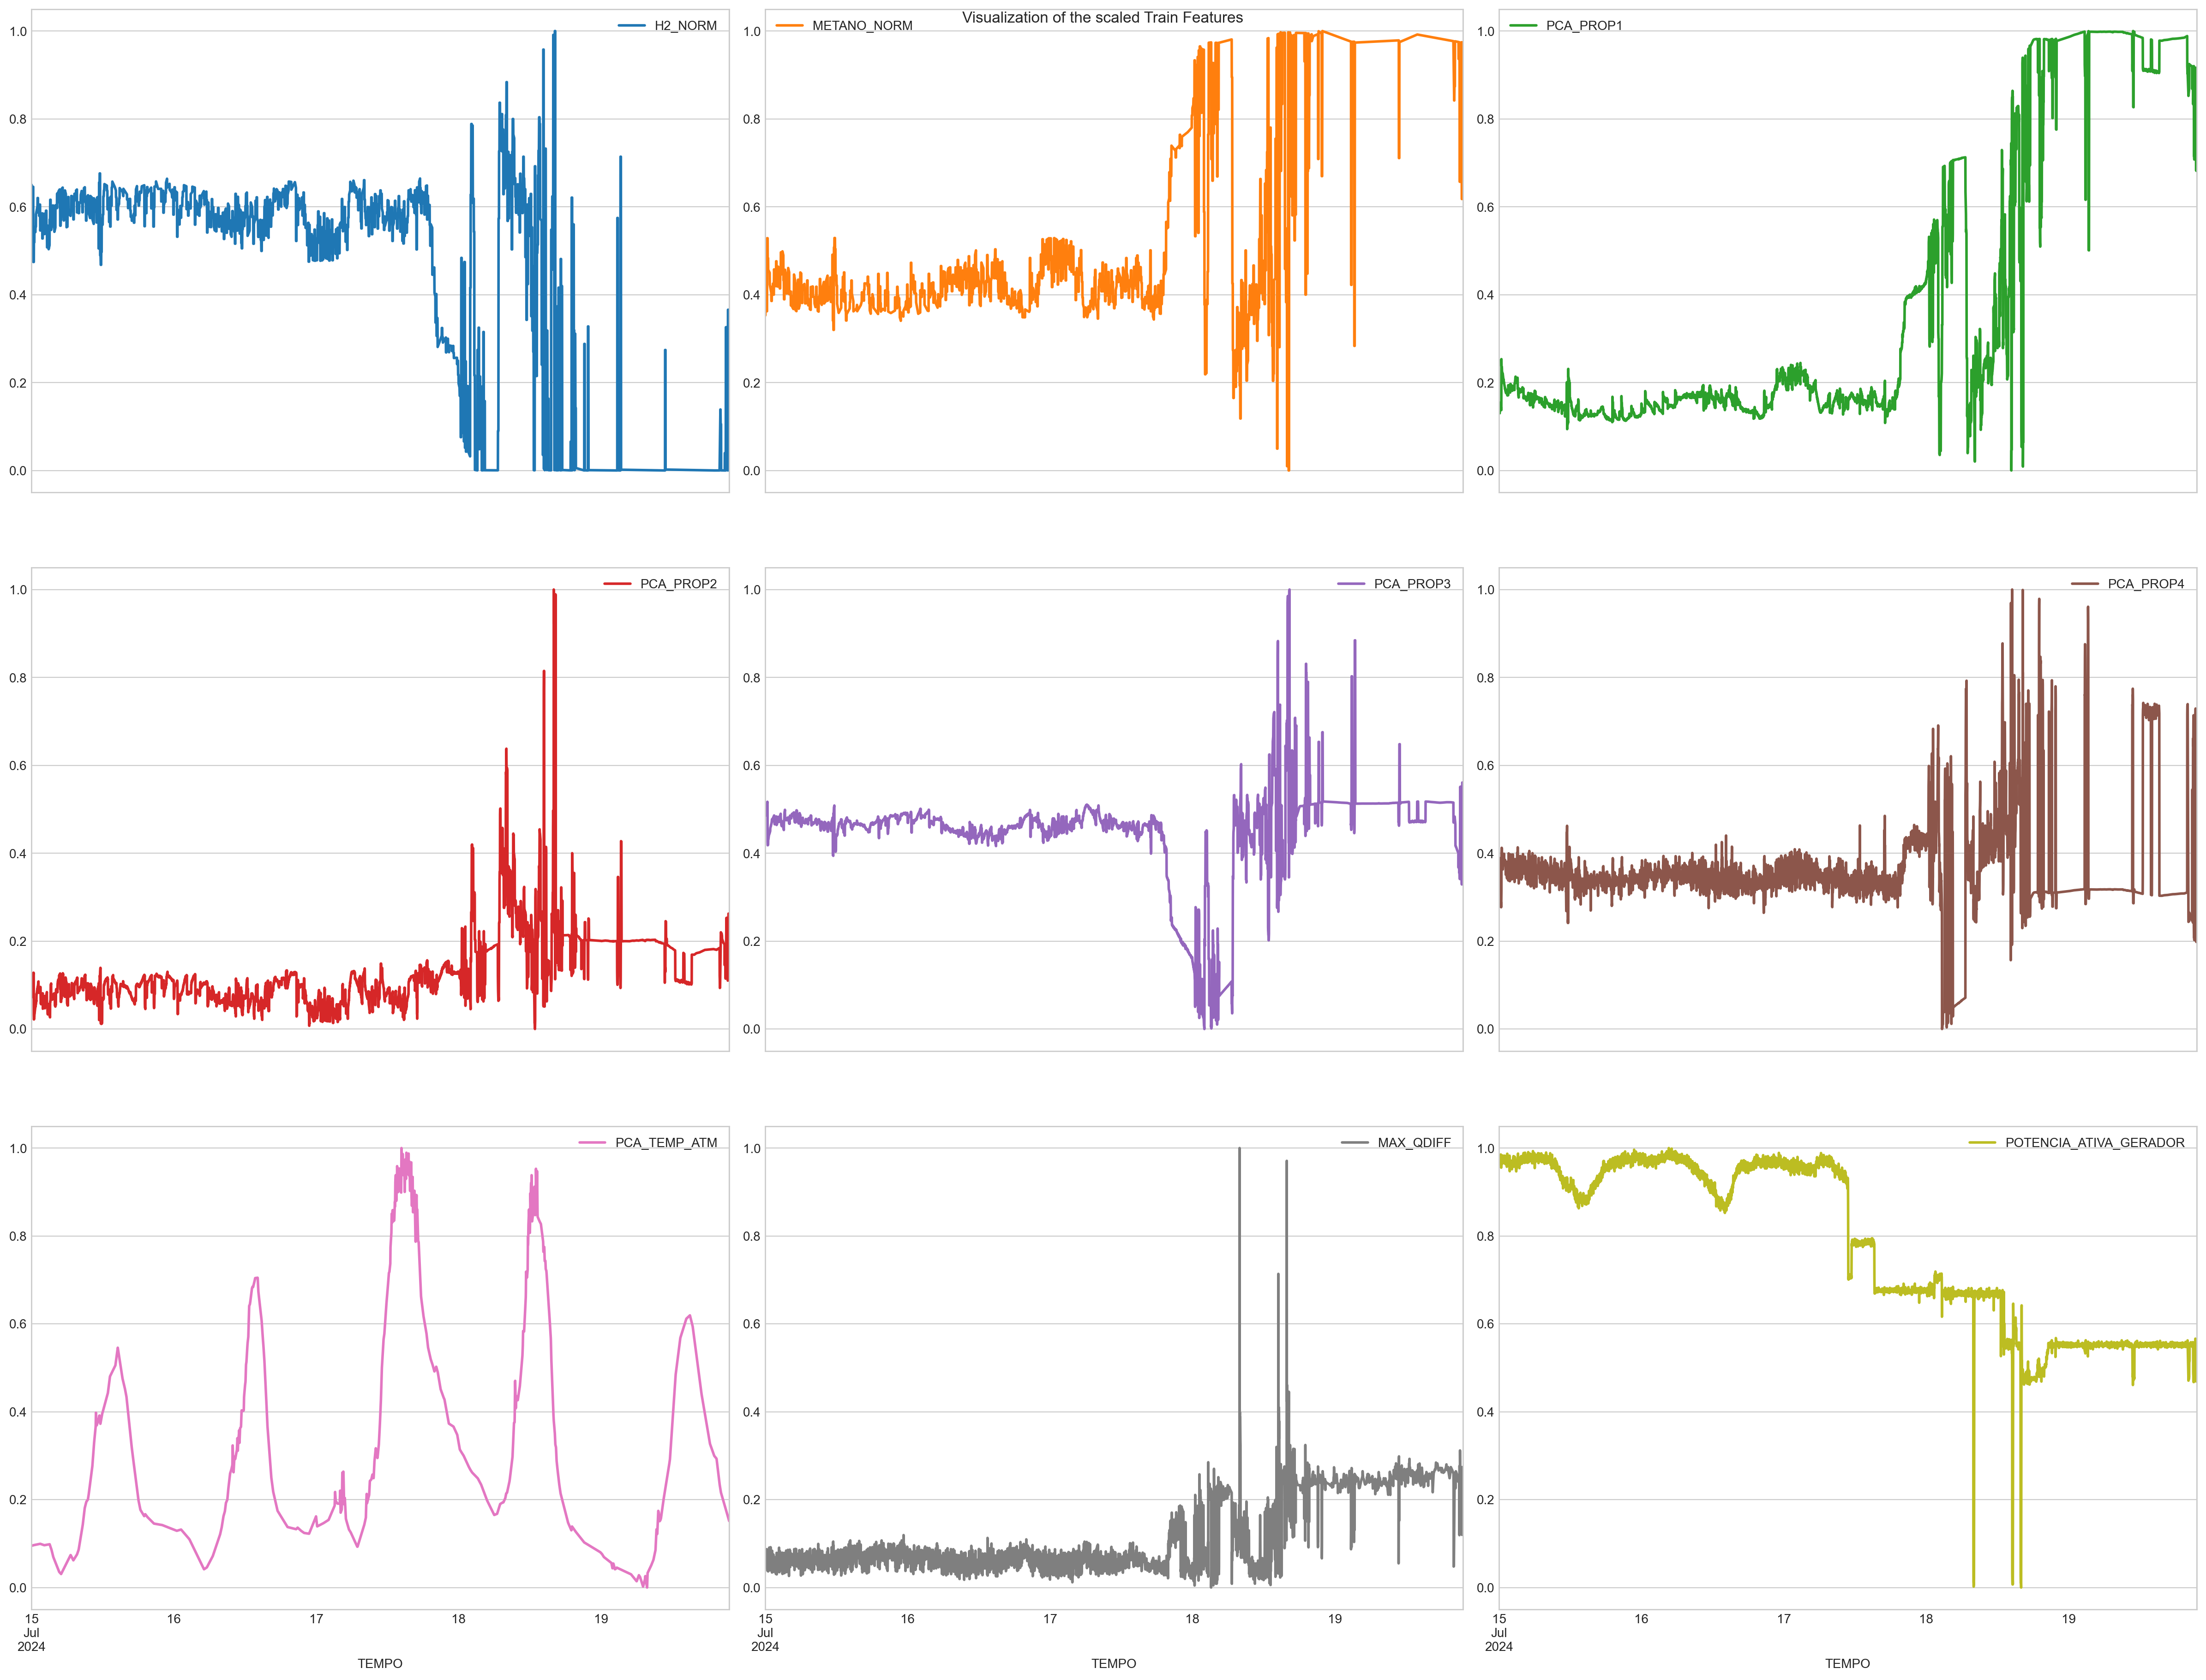

In [29]:
scaled_train_features.plot(subplots=True,
                           layout=(4, 3),
                           figsize=(24,24),
                           fontsize=10, 
                           linewidth=2, 
                           title='Visualization of the scaled Train Features')
plt.show()

# <a name="3"></a> 3. Data Pre-processing for LSTM Model
------------------------------------
Input data for the Keras LSTM layer has 3 dimensions: (M, T, N), where 
* M - number of examples (2D: sequences of timesteps x features), 
* T - sequence length (timesteps) and 
* N - number of features (input_dim)

In [30]:
# Create sequences of T timesteps
T = 45
X_train, y_train = [], []
for i in range(train_labels.shape[0] - (T-1)):
    X_train.append(scaled_train_features.iloc[i:i+T].values)
    y_train.append(train_labels.iloc[i + (T-1)])
X_train, y_train = np.array(X_train), np.array(y_train).reshape(-1,1)
print(f'Train data dimensions: {X_train.shape}, {y_train.shape}')

X_test, y_test = [], []
for i in range(test_labels.shape[0]):
    X_test.append(scaled_test_features.iloc[i:i+T].values)
    y_test.append(test_labels.iloc[i])
X_test, y_test = np.array(X_test), np.array(y_test).reshape(-1,1)  

print(f'Test data dimensions: {X_test.shape}, {y_test.shape}')

Train data dimensions: (7012, 45, 9), (7012, 1)
Test data dimensions: (3025, 45, 9), (3025, 1)


# <a name="4"></a> 4. LSTM Model - Batch Training and Predictiction
-------------------------

In [16]:
# Import Keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.regularizers import l2
from time import time

Using TensorFlow backend.


layers=[8, 8, 8, 1], train_examples=1261, test_examples=382
batch = 1261, timesteps = 45, features = 17, epochs = 50
lr = 0.05, lambda = 0.03, dropout = 0.0, recurr_dropout = 0.0
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 45, 8)             832       
_________________________________________________________________
batch_normalization_1 (Batch (None, 45, 8)             32        
_________________________________________________________________
lstm_2 (LSTM)                (None, 45, 8)             544       
_________________________________________________________________
batch_normalization_2 (Batch (None, 45, 8)             32        
_________________________________________________________________
lstm_3 (LSTM)                (None, 8)                 544       
_________________________________________________________________
batch_normalization_3 (Batch 

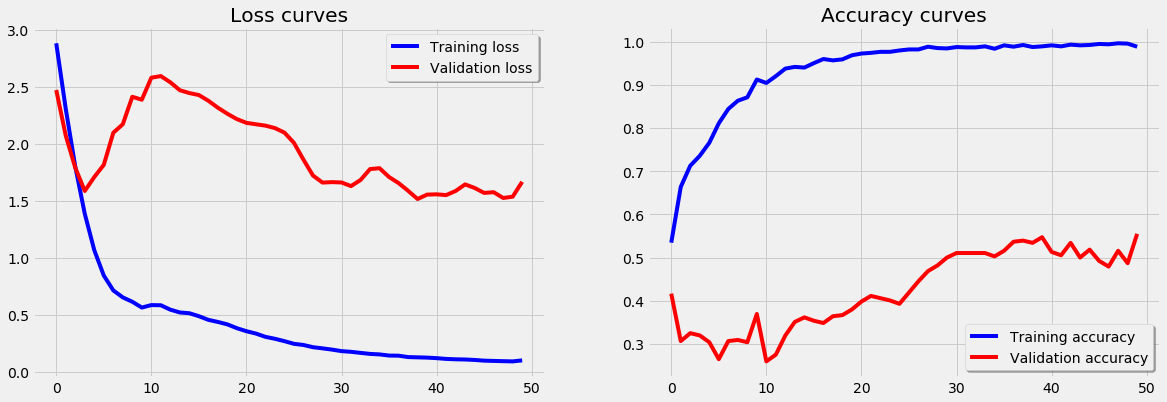

In [17]:
# Let's make a list of CONSTANTS for modelling:
LAYERS = [8, 8, 8, 1]                # number of units in hidden and output layers
M_TRAIN = X_train.shape[0]           # number of training examples (2D)
M_TEST = X_test.shape[0]             # number of test examples (2D),full=X_test.shape[0]
N = X_train.shape[2]                 # number of features
BATCH = M_TRAIN                      # batch size
EPOCH = 50                           # number of epochs
LR = 5e-2                            # learning rate of the gradient descent
LAMBD = 3e-2                         # lambda in L2 regularizaion
DP = 0.0                             # dropout rate
RDP = 0.0                            # recurrent dropout rate
print(f'layers={LAYERS}, train_examples={M_TRAIN}, test_examples={M_TEST}')
print(f'batch = {BATCH}, timesteps = {T}, features = {N}, epochs = {EPOCH}')
print(f'lr = {LR}, lambda = {LAMBD}, dropout = {DP}, recurr_dropout = {RDP}')

# Build the Model
model = Sequential()
model.add(LSTM(input_shape=(T, N), units=LAYERS[0],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model.add(BatchNormalization())
model.add(LSTM(units=LAYERS[1],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model.add(BatchNormalization())
model.add(LSTM(units=LAYERS[2],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=False, return_state=False,
               stateful=False, unroll=False
              ))
model.add(BatchNormalization())
model.add(Dense(units=LAYERS[3], activation='sigmoid'))

# Compile the model with Adam optimizer
model.compile(loss='binary_crossentropy',
              metrics=['accuracy'],
              optimizer=Adam(lr=LR))
print(model.summary())

# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=0, 
                             factor=0.5, min_lr=1e-8)
# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_acc', min_delta=0, 
                           patience=30, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)
# Train the model. 
# The dataset is small for NN - let's use test_data for validation
start = time()
History = model.fit(X_train, y_train,
                    epochs=EPOCH,
                    batch_size=BATCH,
                    validation_split=0.0,
                    validation_data=(X_test[:M_TEST], y_test[:M_TEST]),
                    shuffle=True,verbose=0,
                    callbacks=[lr_decay, early_stop])
print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)
# Evaluate the model:
train_loss, train_acc = model.evaluate(X_train, y_train,
                                       batch_size=M_TRAIN, verbose=0)
test_loss, test_acc = model.evaluate(X_test[:M_TEST], y_test[:M_TEST],
                                     batch_size=M_TEST, verbose=0)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')

# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
axs[0].plot(History.history['loss'], color='b', label='Training loss')
axs[0].plot(History.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)
axs[1].plot(History.history['acc'], color='b', label='Training accuracy')
axs[1].plot(History.history['val_acc'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].legend(loc='best', shadow=True)
plt.show()

In [18]:
y_hat = model.predict_classes(X_test, batch_size=M_TEST, verbose=1)
#score = sum(y_hat == y_test) / len(y_test)
#print(f'Prediction accuracy = {score*100}%')
index = pd.date_range(start='2017-01-02', end='2018-06-19', freq='B')
for i in range(y_hat.shape[0]):
    print(index[i], y_hat[i], y_test[i])

382/382 [==============================] - 0s 1ms/step
2017-01-02 00:00:00 [1] [1]
2017-01-03 00:00:00 [1] [1]
2017-01-04 00:00:00 [1] [1]
2017-01-05 00:00:00 [1] [1]
2017-01-06 00:00:00 [1] [1]
2017-01-09 00:00:00 [1] [1]
2017-01-10 00:00:00 [1] [1]
2017-01-11 00:00:00 [0] [1]
2017-01-12 00:00:00 [0] [1]
2017-01-13 00:00:00 [0] [1]
2017-01-16 00:00:00 [0] [1]
2017-01-17 00:00:00 [0] [1]
2017-01-18 00:00:00 [0] [1]
2017-01-19 00:00:00 [0] [1]
2017-01-20 00:00:00 [0] [1]
2017-01-23 00:00:00 [0] [1]
2017-01-24 00:00:00 [0] [1]
2017-01-25 00:00:00 [0] [1]
2017-01-26 00:00:00 [0] [1]
2017-01-27 00:00:00 [0] [1]
2017-01-30 00:00:00 [0] [1]
2017-01-31 00:00:00 [0] [1]
2017-02-01 00:00:00 [0] [1]
2017-02-02 00:00:00 [0] [1]
2017-02-03 00:00:00 [0] [1]
2017-02-06 00:00:00 [0] [1]
2017-02-07 00:00:00 [0] [1]
2017-02-08 00:00:00 [0] [1]
2017-02-09 00:00:00 [0] [1]
2017-02-10 00:00:00 [0] [1]
2017-02-13 00:00:00 [0] [1]
2017-02-14 00:00:00 [0] [1]
2017-02-15 00:00:00 [1] [1]
2017-02-16 00:00:00 [